In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from simulator import Simulator
from tools_analysis import corrcoef, coef_var
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from tools_plot import savefig, fix_figure, set_style, despine, add_caption
import copy
from IPython.display import display

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from tqdm import tqdm_notebook as tqdm

from causal_optoconnectics.core import hit_rate

In [2]:
plt.rcParams['figure.figsize'] = (8,4)

In [17]:
from params_test import parameters
sim = Simulator(
    parameters, fname='network_raster', data_path='results', 
    stop_time=2, stim_rate=30, stim_dist='poisson', verbose=True,
    stim_amp_ex=0)
sim.simulate(state=False, save=False, raster=True, progress_bar=tqdm)

data = sim.data

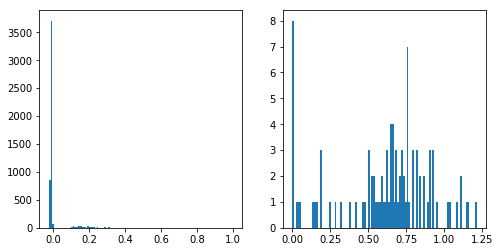

In [19]:
fig, ax = plt.subplots(1, 2)

t_stop = sim.p['status']['time']
binsize_corr = 5.
spiketrains_list = list(spiketrains.values())
spiketrains_sampled = [spiketrains_list[i] for i in np.random.randint(0, len(spiketrains_list), 100)]
cc = corrcoef(
    spiketrains_sampled, t_stop, binsize=binsize_corr)

ax[0].hist(cc[np.triu_indices(len(cc), k=1)], bins=100);


cv = np.array(coef_var(spiketrains_sampled))
cv = cv[~np.isnan(cv)]

ax[1].hist(cv, bins=100);

In [5]:
conn = sim.data['connections']
conn.loc[:,'stimulated'] = conn.source.isin(data['stim_nodes']['ex'])
conn['stim_amp_source'] = conn.progress_apply(lambda x: data['stim_amps']['ex'].get(x.source, 0), axis=1)

HBox(children=(IntProgress(value=0, max=156250), HTML(value='')))

Text(0.5,0,'Synaptic weight [pA]')

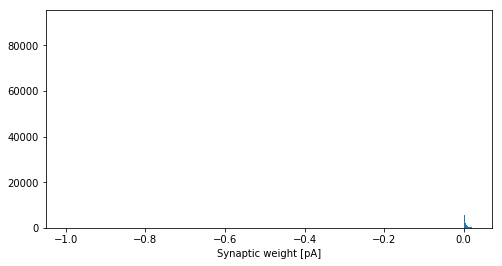

In [6]:
conn.weight.hist(bins=1000)
plt.grid(False)
plt.xlabel('Synaptic weight [pA]')

In [7]:
senders = sim.data['spiketrains']['ex']['senders']
times = sim.data['spiketrains']['ex']['times']
stim_times = sim.data['epoch']['times']
sender_ids = np.unique(senders)

spiketrains = {
    sender: times[sender==senders] for sender in tqdm(sender_ids)}

HBox(children=(IntProgress(value=0, max=989), HTML(value='')))

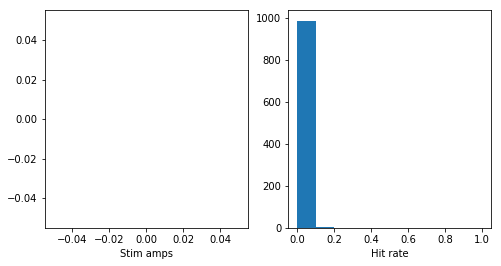

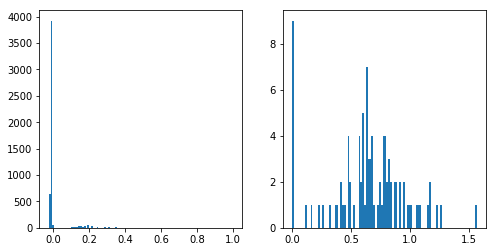

In [12]:
mu = 2
sigma = 2 # not used
hit_rates = [hit_rate(s1, stim_times,  mu=mu, sigma=sigma)
             for s1 in spiketrains.values()]


fig, ax = plt.subplots(1, 2)

amps = np.array(list(sim.data['stim_amps']['ex'].values()))
width = .1
bins = np.arange(0, amps.max(), width)
hist, bins = np.histogram(amps, bins=bins)
# print(bins)
# print(hist, sum(hist))
ax[0].bar(bins[1:], hist, align='edge', width=-width)
ax[0].set_xlabel('Stim amps')

width = .1
bins = np.arange(0, 1+width, width)
hist, bins = np.histogram(hit_rates, bins=bins)
ax[1].bar(bins[1:], hist, align='edge', width=-width)
ax[1].set_xlabel('Hit rate')

In [4]:
def prestim(x, stim_times):
    stim_times = stim_times.astype(float)

    src_x = np.searchsorted(x, stim_times, side='right')

    remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
    src_x = np.delete(src_x, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)
    return x[src_x-1] - stim_times

In [9]:
C = 979
As = conn.query("target=={C} and stimulated".format(C=C))
A = As.sort_values('weight', ascending=False).source.iloc[0]
Bs = conn.query("source!={A} and target!={C} and stimulated".format(A=A, C=C))
B = Bs.source.iloc[0]

A_prestim = prestim(spiketrains[A], data['epoch']['times'])
B_prestim = prestim(spiketrains[B], data['epoch']['times'])
np.corrcoef(A_prestim, B_prestim)[0,1]

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [10]:
A_prestim.shape, B_prestim.shape

((17,), (11,))

In [5]:
def norm(a):
    a = np.array(a)
    b = a - a.min()
    return b / b.max()

In [6]:
stim_times = sim.data['epoch']['times']
spiketrains = {}
neuron_ids = {}
for pop in ['ex', 'in']:
    senders = sim.data['spiketrains'][pop]['senders']
    if pop == 'ex':
        sender_ids = data['stim_nodes'][pop]
    else:
        sender_ids = np.unique(senders)[:250]
    times = sim.data['spiketrains'][pop]['times']
    spiketrains[pop] = [t for sender in sender_ids for t in times[sender==senders]]
    neuron_ids[pop] = [s for sender in sender_ids for s in [sender] * sum(sender==senders)]

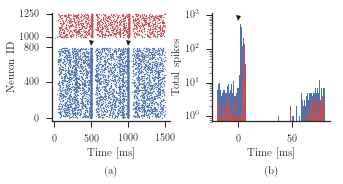

In [9]:
set_style('article', sns_style='ticks')
size = 1 # 10 # notebook
arrow_size = 5 # 25 # notebook
color = {'ex': 'b', 'in': 'r'}
width = 3
xmin = -20
xmax = 80

fig = plt.figure()
gs0 = GridSpec(1, 2, wspace=.35)

gs00 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0], **{'height_ratios': [1, 800/250], 'hspace': 0.01})
ax1 = fig.add_subplot(gs00[0, 0])
ax2 = fig.add_subplot(gs00[1, 0])

ax1.scatter(spiketrains['in'], neuron_ids['in'], color='r', s=size)
despine(xticks=False, bottom=True, ax=ax1)

ax2.scatter(spiketrains['ex'], neuron_ids['ex'], s=size)
despine(ax=ax2)
ax2.set_yticks([0, 400, 800])
ax2.set_xticks([0, 500, 1000, 1500])

y = 850
ax2.plot([500, 1000], [y, y], ls='none', marker='v', color='k', markersize=arrow_size)

ax2.set_xlabel('Time [ms]')
fig.text(0.0, 0.5, 'Neuron ID', va='center', rotation='vertical')


gs01 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1])
ax = fig.add_subplot(gs01[0, 0])

for pop in ['ex', 'in']:
    spikes = []
    for t in [500, 1000]:
        sptr = np.array(spiketrains[pop]) - t
        sptr = sptr[(sptr > xmin) & (sptr < xmax)]
        spikes.extend(sptr.tolist())
    
#     bins = np.arange(xmin, xmax + width, width)
#     hist, bins = np.histogram(spikes, bins=bins)
#     ax.bar(bins[1:], hist, color=color[pop], width=-width, align='edge')
    ax.hist(spikes, color=color[pop], bins=100, log=True)

ax.plot(0, 850, ls='none', marker='v', color='k', markersize=arrow_size)
despine()
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Total spikes')
add_caption([ax2, ax], start='a')
savefig(fig, 'network-raster')